## Customer flow in the DOODL supermarket

The following notebook analyzes and simulates the movement of customers in the exemplary DOODL supermarket. In the first part, tracked customer data will be analyzed and visualized. In the second part, the customer movement will be simulated using a Markov Chain Simulator. 

In [1]:
import pandas as pd
import seaborn as sns
import pylab as plt
import numpy as np, numpy.random
import markov

sns.set(palette= 'coolwarm', style= 'darkgrid')
sns.set_context("notebook",font_scale=1.5, rc={"lines.linewidth": 2.5, 'figure.figsize':(13.0,8.27)})

## 1. Customer Data Analysis

In [2]:
monday = pd.read_csv('data/monday.csv', sep=";", )
tuesday = pd.read_csv('data/tuesday.csv', sep=";")
wednesday = pd.read_csv('data/wednesday.csv', sep=";")
thursday = pd.read_csv('data/thursday.csv', sep=";")
friday = pd.read_csv('data/friday.csv', sep=";")

In [3]:
monday['timestamp'] = pd.to_datetime(monday.timestamp, infer_datetime_format=True)
tuesday['timestamp'] = pd.to_datetime(tuesday.timestamp, infer_datetime_format=True)
wednesday['timestamp'] = pd.to_datetime(wednesday.timestamp, infer_datetime_format=True)
thursday['timestamp'] = pd.to_datetime(thursday.timestamp, infer_datetime_format=True)
friday['timestamp'] = pd.to_datetime(friday.timestamp, infer_datetime_format=True)

In [4]:
# Merge all dataframes 
monday['weekday'] = "monday"
tuesday['weekday'] = "tuesday"
wednesday['weekday'] = "wednesday"
thursday['weekday'] = "thursday"
friday['weekday'] = "friday"

In [5]:
frames = [monday, tuesday, wednesday, thursday, friday]
week = pd.concat(frames)

### 1.1 Total number of customers in each section (over time)

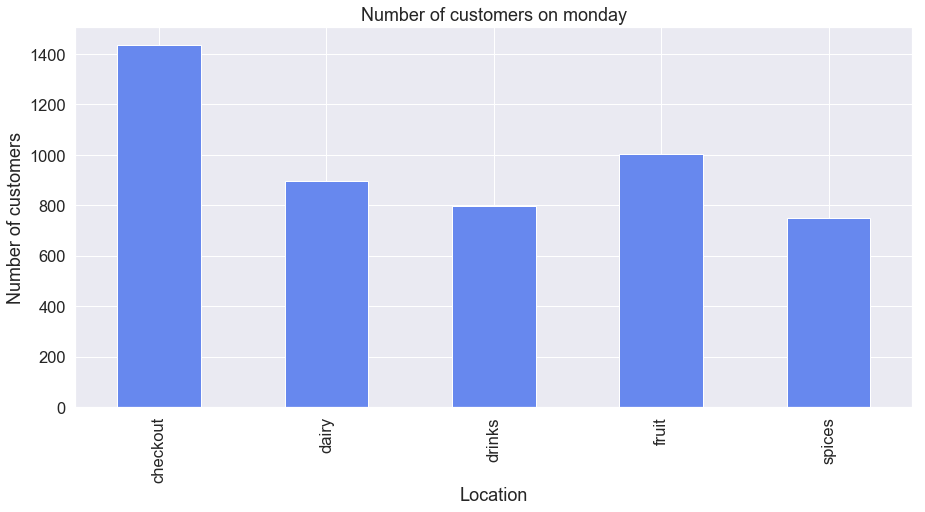

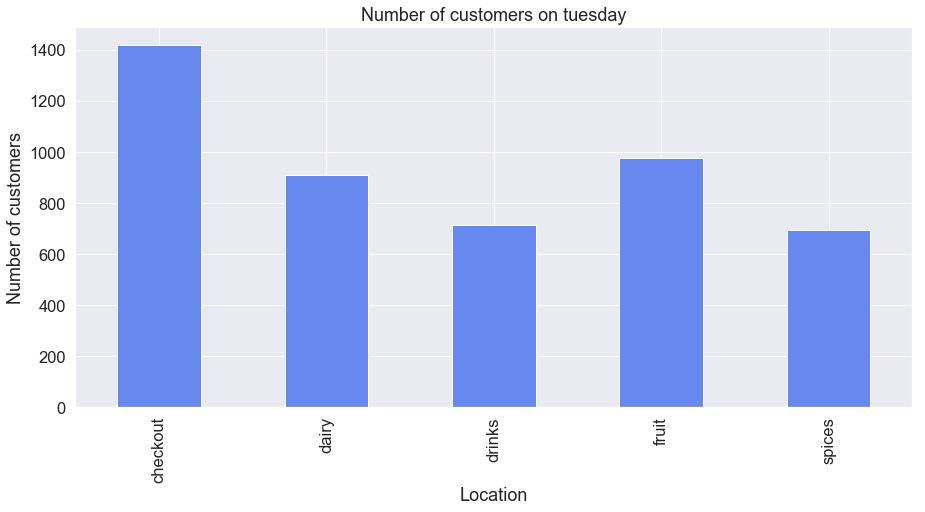

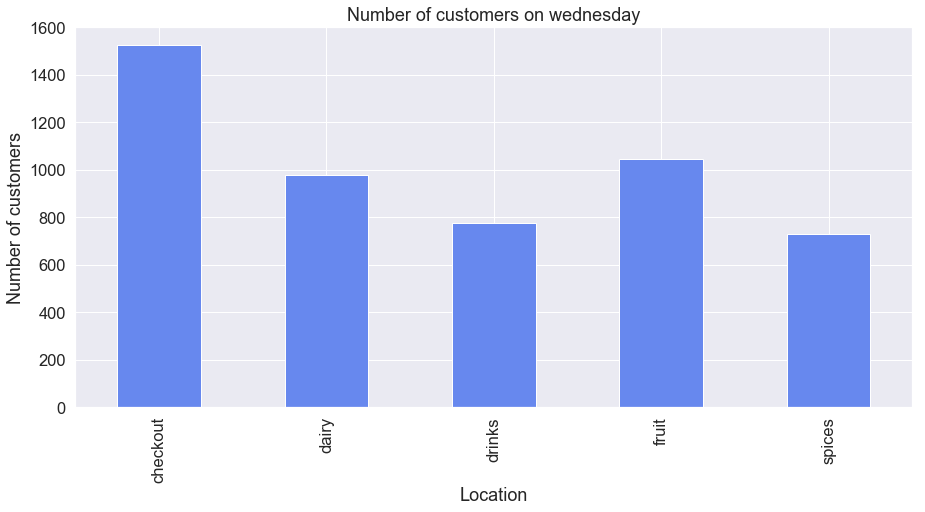

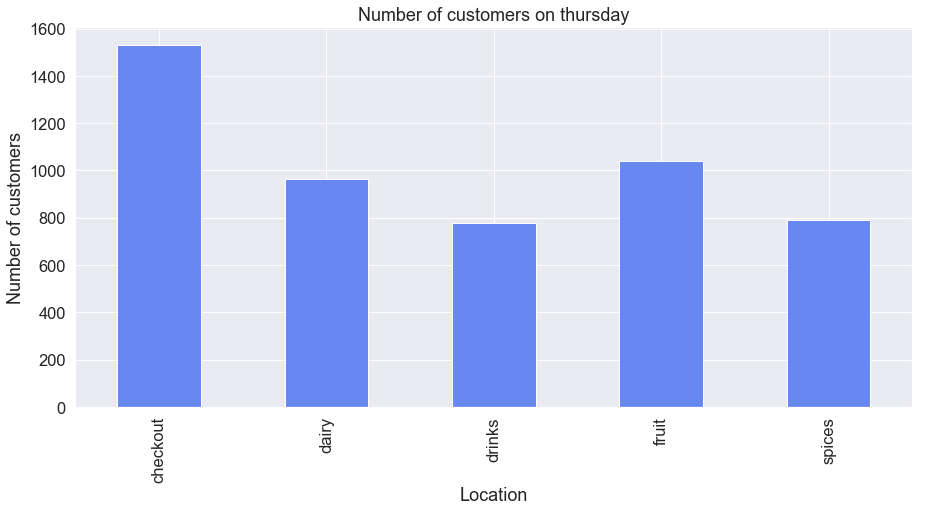

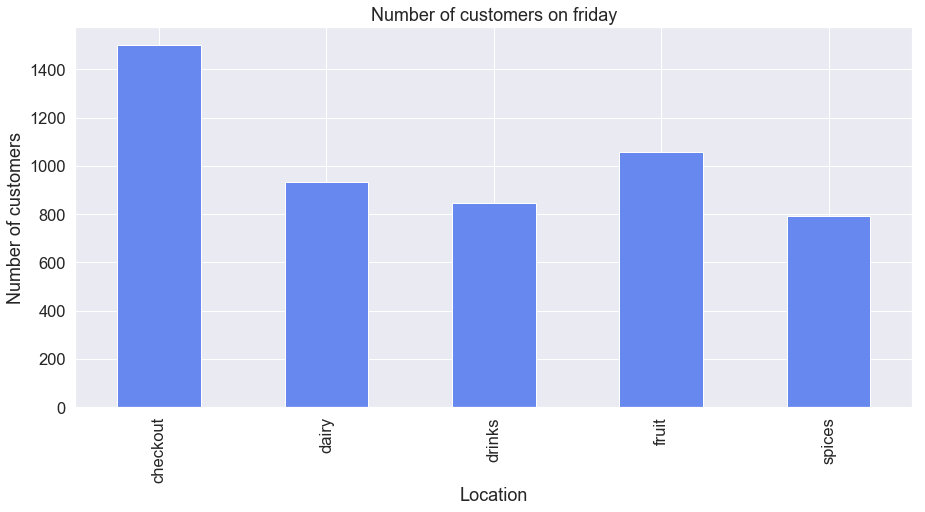

In [6]:
# Calculate the total number of customers in each section
for day in week.weekday.unique():
    plt.figure()
    week.loc[week.weekday==day].groupby('location')['customer_no'].count().plot("bar", figsize=(15,7))
    plt.title('Number of customers on {day}'.format(day=day))
    plt.xlabel('Location')
    plt.ylabel('Number of customers')

In [7]:
weekdays = [monday,tuesday,wednesday,thursday,friday]

<Figure size 432x288 with 0 Axes>

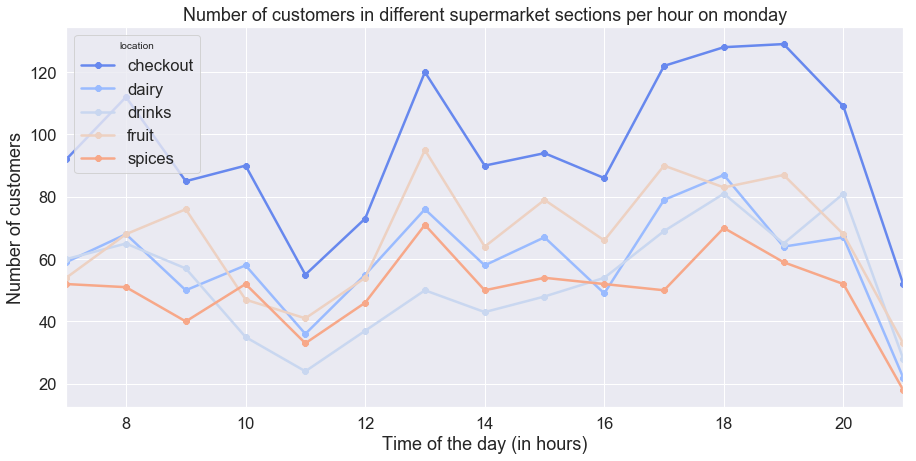

<Figure size 432x288 with 0 Axes>

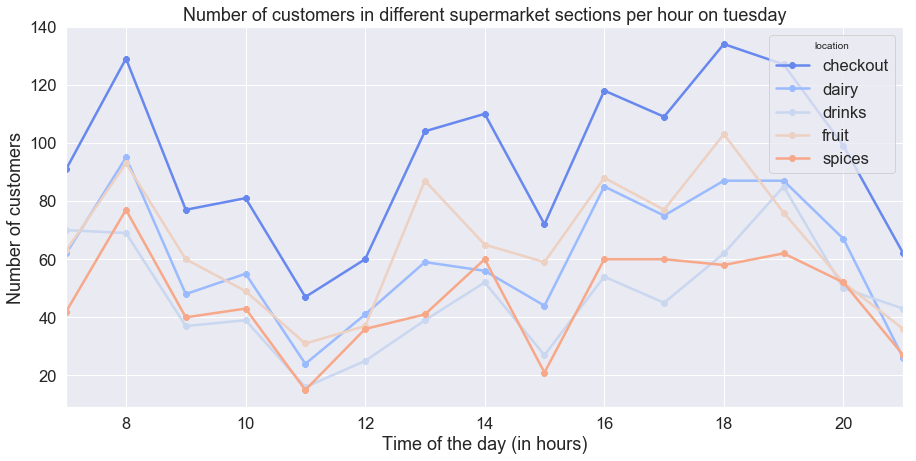

<Figure size 432x288 with 0 Axes>

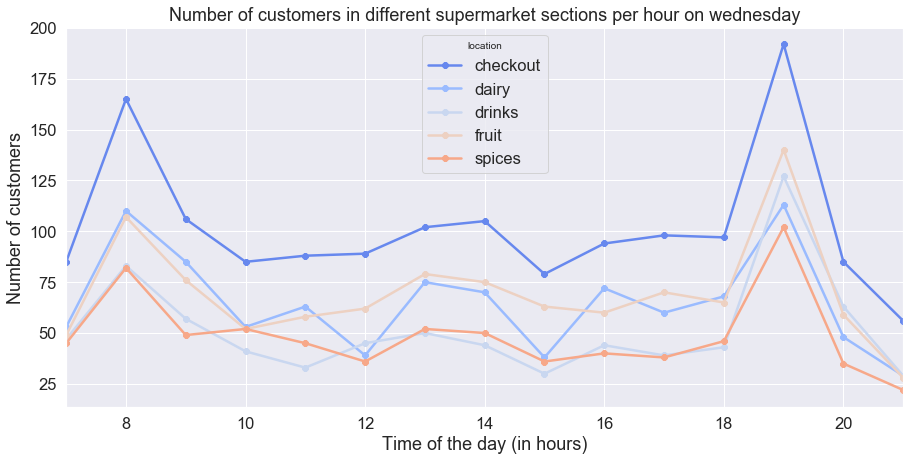

<Figure size 432x288 with 0 Axes>

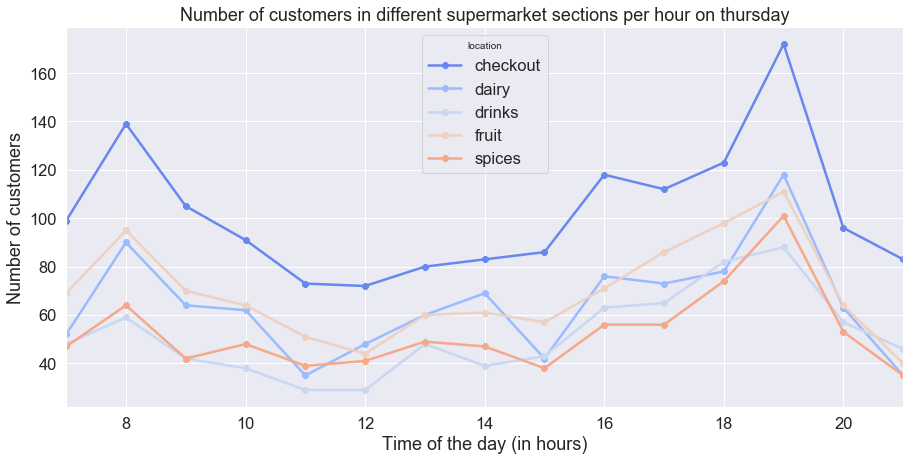

<Figure size 432x288 with 0 Axes>

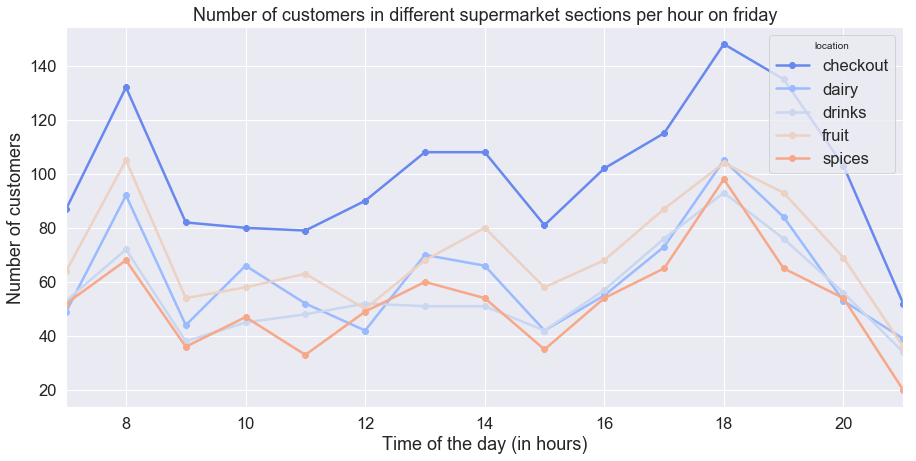

In [8]:
# Calculate the total number of customers in each section over time
for day in weekdays:
    plt.figure()
    day.groupby([day.timestamp.dt.hour, day.location])["customer_no"].count().unstack(1).plot(figsize=(15,7), marker="8")
    plt.title('Number of customers in different supermarket sections per hour on {day}'.format(day=day.weekday[0]))
    plt.xlabel("Time of the day (in hours)")
    plt.ylabel("Number of customers")

### 1.2 Number of customers at checkout over time

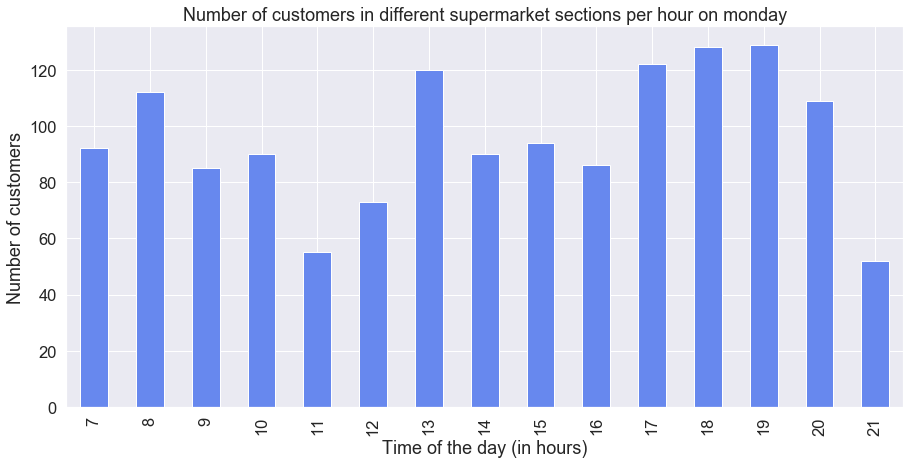

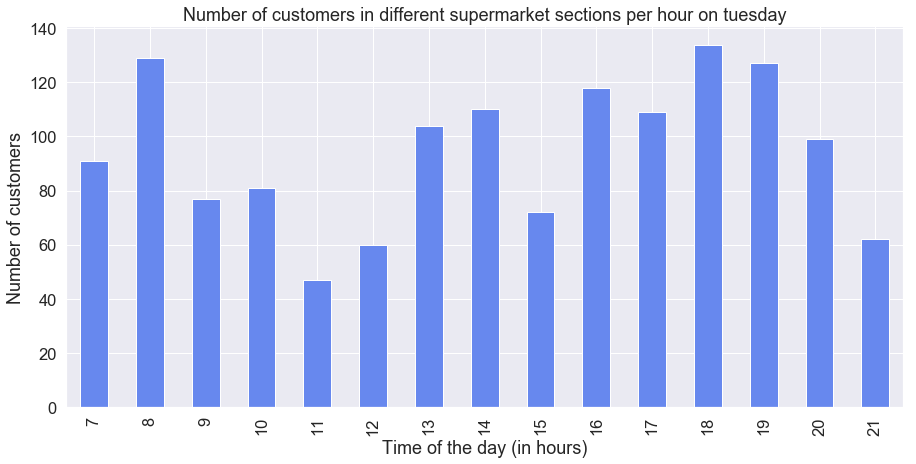

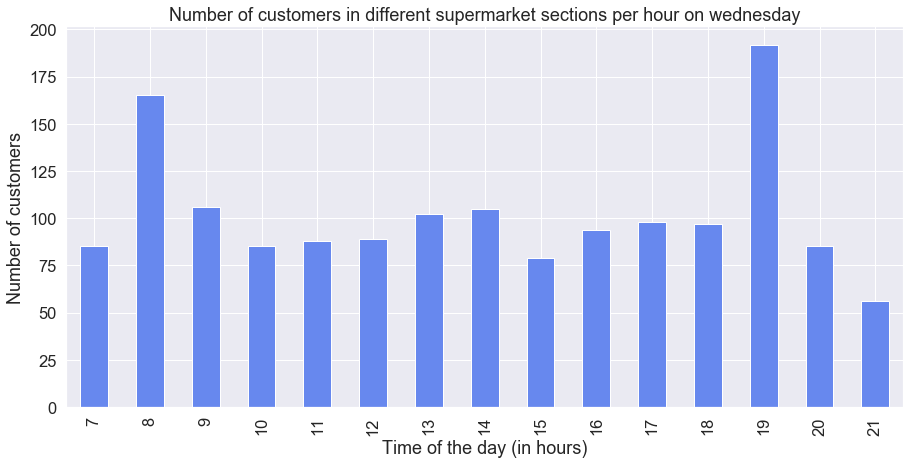

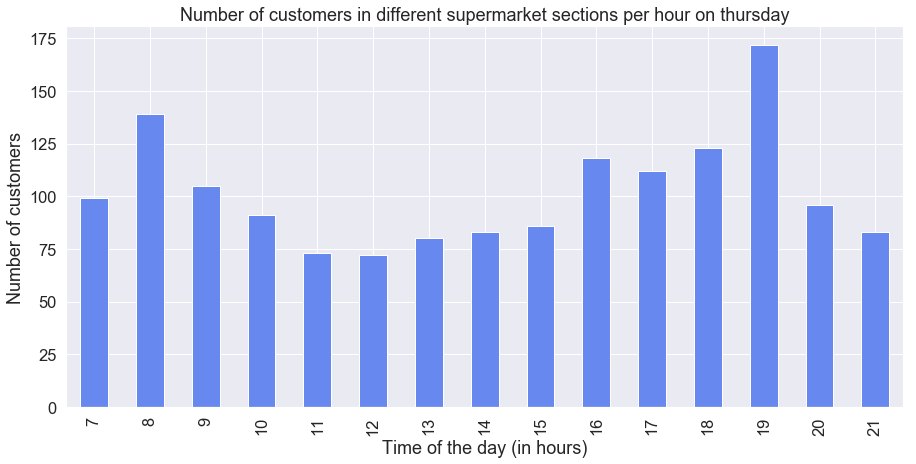

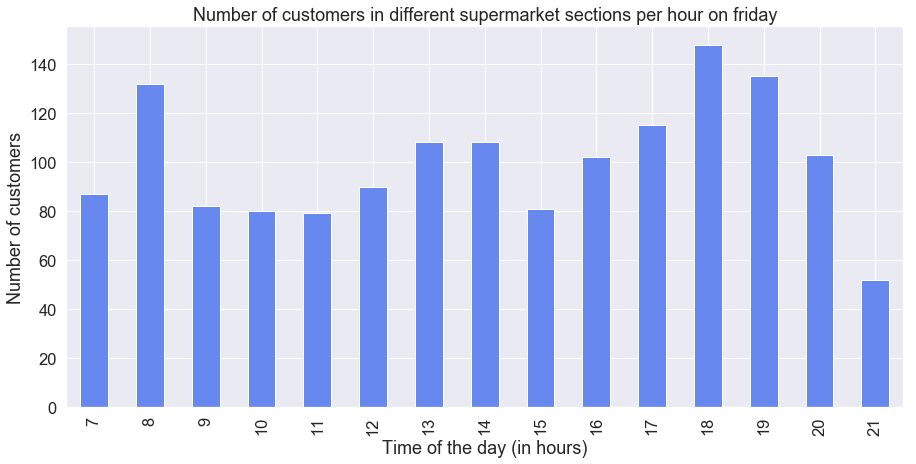

In [9]:
for day in weekdays:
    plt.figure()
    day.loc[day.location=="checkout"].groupby(day.timestamp.dt.hour)["customer_no"].count().plot("bar", figsize=(15,7))
    plt.title('Number of customers in different supermarket sections per hour on {day}'.format(day=day.weekday[0]))
    plt.xlabel("Time of the day (in hours)")
    plt.ylabel("Number of customers")

### 1.3 Average time spent in the supermarket 

In [10]:
durations = []
for day in weekdays:
    durations.append(np.mean(day.groupby("customer_no")["timestamp"].max()- \
            day.groupby("customer_no")["timestamp"].min()).total_seconds()/60)

Text(0.5, 1.0, 'Average time spent in the supermarket per customer')

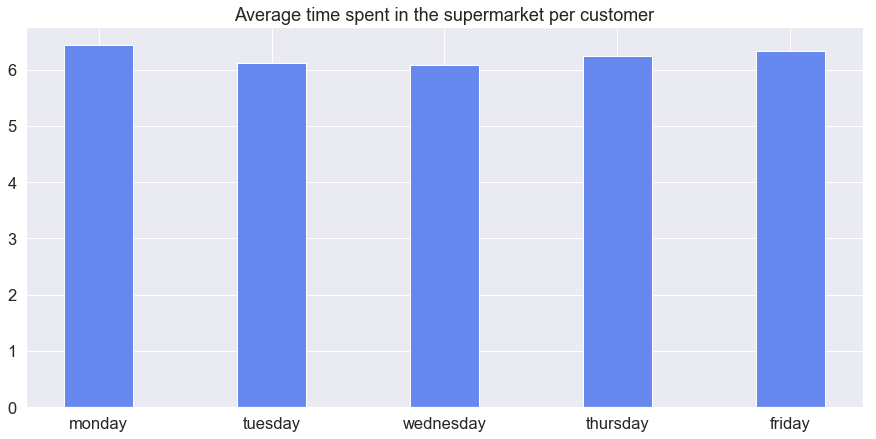

In [11]:
plt.figure(figsize=[15,7])
plt.bar(week.weekday.unique(),durations, width=0.4)
plt.title('Average time spent in the supermarket per customer')

### 1.4 Total number of customers in the supermarket over time

Text(0.5, 1.0, 'Total number of customers per weekday')

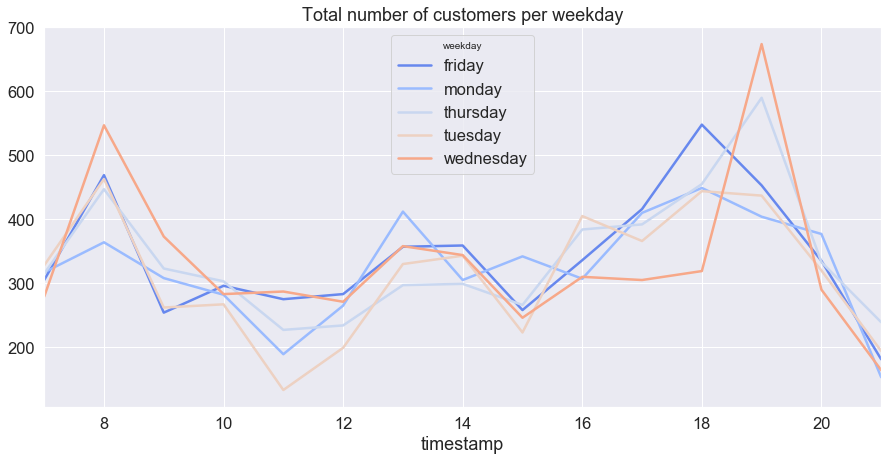

In [12]:
week.groupby([week.weekday,week.timestamp.dt.hour])["customer_no"].count().unstack(0).plot(figsize=(15,7))
plt.title('Total number of customers per weekday')

### 1.5 Plot the distribution of customers of their first visited section versus following sectors

Our business managers think that the first section customers visit follows a different pattern
than the following ones. Plot the distribution of customers of their first visited section versus
following sections (treat all sections visited after the first as “following”).

In [13]:
week_new = week.sort_values(by= ['weekday','customer_no'])

In [14]:
ind = pd.Series(range(0,len(week_new)))
week_new.set_index(ind,inplace=True)

In [15]:
week_new['cust1']= week_new.customer_no.shift()

In [16]:
week_new['purchase']= ["following" if week_new.customer_no[i]== week_new.cust1[i] else "first" for i in week_new.index]

Text(0.5, 0, '')

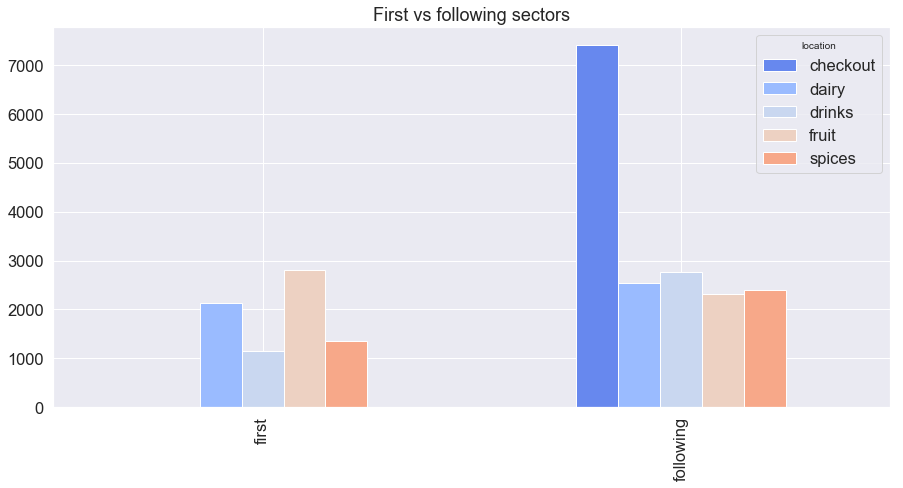

In [17]:
week_new.groupby(['location', 'purchase'])['location'].count()\
    .unstack(0).plot(kind= "bar", stacked= False, figsize= (15,7))
plt.title('First vs following sectors')
plt.xlabel("")

### 1.6 What is the total revenue for a customer? 

In [18]:
price_dict = {"fruit":4, "spices":3, "dairy":5, "drinks":6}

In [19]:
week_new['price'] = week_new['location'].map(price_dict)

In [20]:
week_new["time_after"] = week_new.timestamp.shift(-1)

In [21]:
week_new["revenue"] = (week_new.time_after.dt.minute-week_new.timestamp.dt.minute)

In [141]:
cust_rev = week_new[(week_new.revenue > 0) & (week_new.location != "checkout")]

In [142]:
cust_rev["revenue"] = cust_rev.revenue * cust_rev.price

/Users/leona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [143]:
cust_rev_clr = cust_rev.groupby(['weekday']).agg({'customer_no':'nunique', 'revenue': 'sum'}).rename(columns={'customer_no':'nr_of_customers', 'revenue': 'total_revenue'})
cust_rev_clr['revenue_per_cust'] = cust_rev_clr.total_revenue/cust_rev_clr.nr_of_customers

In [144]:
cust_rev_clr.revenue_per_cust.mean()

27.424984618947953

### 1.7 What is the most profitable section?

In [147]:
cust_rev_sec = cust_rev.groupby(['weekday','location']).agg({'revenue': 'sum', 'customer_no':'nunique'}).rename(columns={'revenue': 'total_revenue', 'customer_no':'nr_of_customers'})
cust_rev_sec['revenue_per_cust'] = cust_rev_sec.total_revenue/cust_rev_sec.nr_of_customers

In [155]:
cust_rev_sec['rel_rev'] = cust_rev_sec.total_revenue/cust_rev.groupby('weekday').customer_no.nunique()

Text(0, 0.5, 'revenue in €')

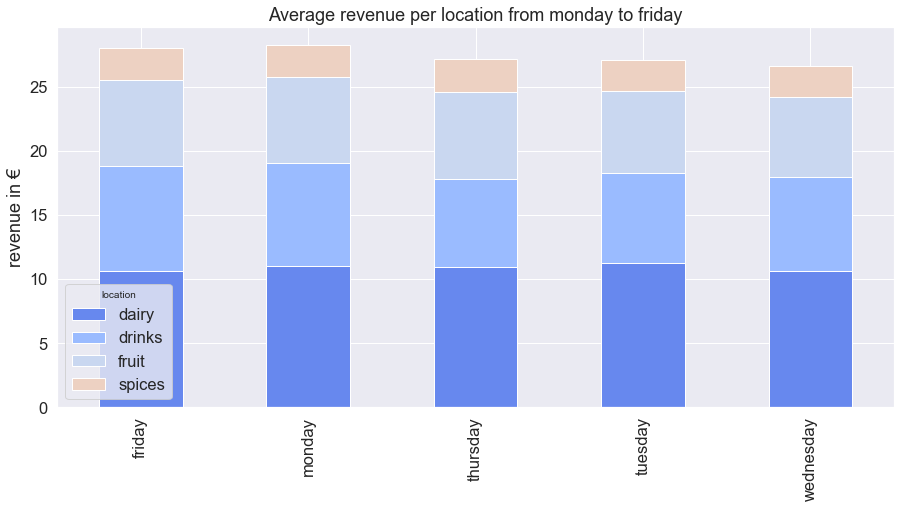

In [157]:
cust_rev_sec.unstack(1).rel_rev.plot(kind= "bar", stacked= True, figsize= (15,7))
plt.title('Average revenue per location from monday to friday')
plt.xlabel('')
plt.ylabel('revenue in €')

### 5 – Transitions

We want to analyse how people switch between flavors. Visualise the probability of flavor
transitions, i.e. of a customer buying flavor B after buying flavor A for all pairs of flavors. If a
customer’s last purchase has occurred more than 6 months before the latest date in the dataset,
we consider him as “churned”, and we record a transition from his last flavor to a special state
called “churned”.

In [ ]:
five= three


In [ ]:
def is_churned(df):
    """Detects churned customers in dataframe containing datetime and customer_id column
    --> Churnday= Critical date --> in this case 6 months before last purchase
    """
    churnday= df.date.max()- pd.Timedelta('0.5 Y')
    df['cust_after']= df.customer_id.shift(-1)
    chur= []
    for i,row in df.iterrows():
        if row.customer_id != row.cust_after and row.date < churnday:
            chur.append('Churned')
        elif row.customer_id == row.cust_after:
            chur.append('Not_last')
        else:
            chur.append('Active')
    return chur

In [ ]:
def get_transition(df):
    """ Assigns next state (e.g. 'Churned') to list based on first and following purchases"""
    df['flavor_after']= df.flavor.shift(-1)
    trans_col= []
    for i,row in df.iterrows():  
        if row.churned == 'Not_last':
            trans_col.append(row.flavor_after)
        elif row.churned== 'Churned':
            trans_col.append('Churned')
        else:
            trans_col.append('other')
            
    return trans_col

In [ ]:
five['churned']= is_churned(five)
five['trans']= get_transition(five)

In [ ]:
pmatrix= five[five.trans!= 'other'].groupby(['flavor', 'trans'])['trans'].count().unstack(1)
pmatrix=pmatrix[['Apple', 'Banana', 'Coffee', 'Doughnut', 'Churned']]

In [ ]:
tmatrix= pmatrix.div((pmatrix.sum(axis=1)), axis= 'rows')

In [ ]:
tmatrix.plot(kind= "bar", stacked= False, figsize= (15,7))
plt.xlabel("")

## Markov Chain simulation

In [ ]:
tmatrix.loc['Churned']= [0.0,0.0,0.0,0.0, 1.0]

In [ ]:
state_list = pd.Series(np.array([100,100,100,100,0]),index=['Apple','Banana','Coffee','Dougnut','Churned'])

### Define Markow Chain Class

In [ ]:
import markov

In [ ]:
babbel= markov.MarkovChain(tmatrix= tmatrix, states= ['Apple', 'Banana', 'Coffee', 'Doughnut', 'Churned'])

In [ ]:
babbel.generate_states(current_state= 'Banana', step_nr= 3)

In [ ]:
market_price= new_df.groupby(['market','flavor'])['price'].mean().unstack(1)
market_price['Churned']= [0 for i in market_price.index]

In [ ]:
df= babbel.cust_nr(state_list, step_nr=20, new_quote=0.75)

In [ ]:
df

In [ ]:
df_price= babbel.get_clv('AUT', market_price, state_list, step_nr=10)

In [ ]:
df.plot(figsize=(15,7), marker="8", ylim= (0,1000))
plt.ylabel('Customer State')
plt.xlabel('Timesteps')

### Plot customer lifetime revenue per market

In [ ]:
for market in market_price.index:
    df_price.plot(figsize= (15,7), marker= "8")
    plt.ylabel('Customer Revenue in €')
    plt.xlabel('Timesteps')
    plt.title('Revenue in {mark} over time'.format(mark= market))

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
df_price.values

In [ ]:
init_state= np.array(state_list)

In [ ]:
import test_3 as test

In [ ]:
babbel= test.MarkovChain(tmatrix= tmatrix, states= ['Apple', 'Banana', 'Coffee', 'Doughnut', 'Churned'])

In [ ]:
df= babbel.cust_nr_churned(state_list, step_nr=20, new_quote=0.75)

In [ ]:
cust_nr_churn(state_list, 10, 0.75)